<a href="https://colab.research.google.com/github/vilsonrodrigues/Hybrid-Images/blob/main/Hybrid_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse trabalho buscou desenvolver uma forma de ocultação de informação usando a Transformada Discreta de Fourier. Uma imagem vai passar pelo filtro passa-baixa e a outra vai passar pelo filtro passa-alta e irão se unir pra formar uma nova imagem. Conforme vai aumentando a sua distância para a imagem, as altas frequências da imagem vão passando a ser imperceptíveis. Essa característica de ocultação permite explorar técnicas de segurança da informação.

https://dl.acm.org/doi/abs/10.1145/1141911.1141919

In [ ]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

In [ ]:
def readImage(fname):
  return Image.open(fname)

In [ ]:
def convertToGray(img):
  img_gray = img.convert("L")
  return np.asarray(img_gray)

In [ ]:
def getHeightWidth(img):
  if len(img.shape) == 2:
    axisX, axisY = img.shape
  elif len(img.shape) == 3:
    axisX, axisY, _ = img.shape
  return axisX, axisY

A DFT depende diretamente do tamanho da imagem, portanto devemos encontrar o melhor tamanho para a imagem, geralmente o melhor tamanho é múltiplo de dois, três ou cinco. Para obter o tamanho ideal será utilizada a função getOptimalDFTSize.(). 

A Transformada de Fourier é uma transformada capaz de expressar um sinal contínuo como uma combinação de funções de base senoidais ponderadas por coeficientes. A Transformada Discreta de Fourier, por sua vez, é aplicada a sinais discretos, tais como imagens digitais.

Para uma imagem digital, a Transformada Discreta de Fourier (ou DFT), é capaz de fornecer uma representação alternativa dessa imagem no domínio da frequência, evidenciando degradações que não são facilmente tratadas no domínio espacial.

In [ ]:
fname = "lamem.jpg"

In [ ]:
img = readImage(fname)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
img_gray = convertToGray(img)

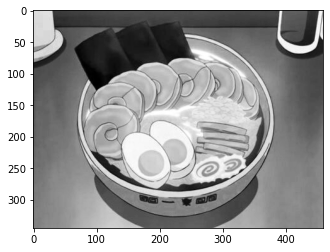

In [ ]:
plt.imshow(img_gray, cmap="gray")

In [ ]:
def dft2D(img):
    # Apply dft
    img_dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    # Shif espectrum
    img_dft = np.fft.fftshift(img_dft)
    # Get dimensions from image
    height, width = getHeightWidth(img)
    # Magnetude from spectrum
    magnetude = cv2.magnitude(img_dft[:, :, 0], img_dft[:, :, 1])
    magnetude_spectrum = 20 * np.log(magnetude)    
    
    return img_dft, magnetude_spectrum, height, width

In [ ]:
img_dft, magnetude_spectrum, height, width = dft2D(img_gray)

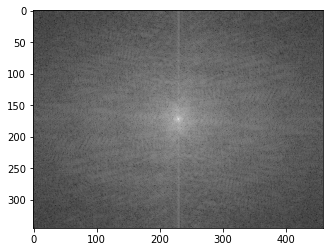

In [ ]:
plt.imshow(magnetude_spectrum, cmap="gray")

In [ ]:
def createMaskLowPassIdealFilter(height, width, RADIUS):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
          if((i - dft_M / 2) * (i - dft_M / 2) + (j - dft_N / 2) * (j - dft_N /2) < RADIUS * RADIUS):
              tmp[i][j] = 1.0
  return tmp

In [ ]:
def createMaskHighPassIdealFilter(height, width, RADIUS):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
          if((i - dft_M / 2) * (i - dft_M / 2) + (j - dft_N / 2) * (j - dft_N /2) > RADIUS * RADIUS):
              tmp[i][j] = 1.0
  return tmp

In [ ]:
def createMaskHighPassGaussianFilter(height, width, RADIUS):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
          tmp[i][j] = (1 - np.exp( -	( (i - dft_M/2)* (i - dft_M/2) + (j - dft_N/2) * (j - dft_N/2) ) / (RADIUS*RADIUS)))              
  return tmp

In [ ]:
def createMaskLowPassGaussianFilter(height, width, RADIUS):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
          tmp[i][j] = (- np.exp( -	( (i-dft_M/2)*(i-dft_M/2) + (j-dft_N/2)*(j-dft_N/2) ) / (RADIUS*RADIUS)))              
  return tmp

Os filtros butter não ficaram tão bons, devo ter implementado algo errado apesar de ter seguido a fórmula

In [ ]:
def createMaskHighPassButterFilter(height, width, RADIUS, n):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
        D = ((i - dft_M/2 ) + (j - dft_N/2 ))
        if D == 0.0: D = 0.0001
        tmp[i][j] = (1 / (1 + (RADIUS /  D)**(2*n) ))
  return tmp

In [ ]:
def createMaskLowPassButterFilter(height, width, RADIUS, n):
  tmp = np.zeros((height, width, 2), dtype=np.float32)
  dft_M = cv2.getOptimalDFTSize(height)
  dft_N = cv2.getOptimalDFTSize(width)
  for i in range(height):
      for j in range(width):
        tmp[i][j] = (1 / (1 + ( ((i - dft_M/2) + (j - dft_N/2)) / RADIUS )**(2*n) ) )
  return tmp

In [ ]:
maskLP_butter = createMaskLowPassButterFilter(200, 200, 30, 1)

In [ ]:
maskHP_butter = createMaskHighPassButterFilter(200, 200, 30, 1)

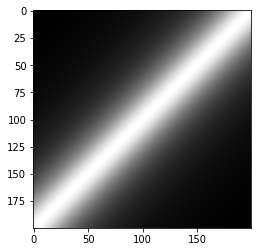

In [ ]:
plt.imshow(maskLP_butter[:,:,0], cmap="gray")

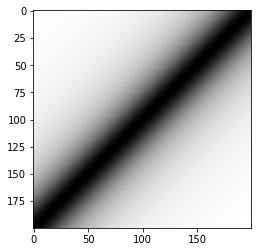

In [ ]:
plt.imshow(maskHP_butter[:,:,0], cmap="gray")

In [ ]:
maskHP_ideal = createMaskHighPassIdealFilter(200, 200, 30)

In [ ]:
maskLP_ideal = createMaskLowPassIdealFilter(200, 200, 30)

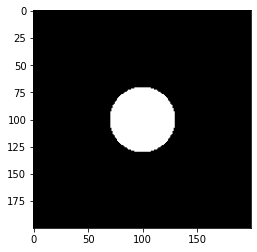

In [ ]:
plt.imshow(maskLP_ideal[:,:,0], cmap="gray")

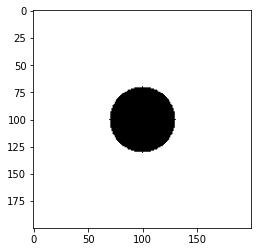

In [ ]:
plt.imshow(maskHP_ideal[:,:,0], cmap="gray")

In [ ]:
maskHP_gauss = createMaskHighPassGaussianFilter(200, 200, 70)

In [ ]:
maskLP_gauss = createMaskLowPassGaussianFilter(200, 200, 30)

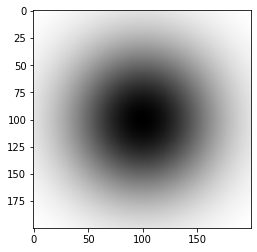

In [ ]:
plt.imshow(maskHP_gauss[:,:,0], cmap="gray")

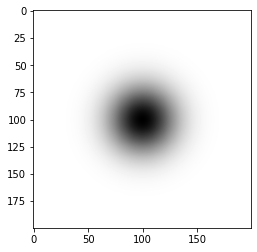

In [ ]:
plt.imshow(maskLP_gauss[:,:,0], cmap="gray")

In [ ]:
def applyFilter(img_dft, mask):
  # Apply filter
  img_filtered = np.multiply(img_dft, mask)
  # ifft shift
  img_filtered_ishift = np.fft.ifftshift(img_filtered)
  # ifft
  img_back = cv2.idft(img_filtered_ishift)
  img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
  return img_back.astype(np.float32)

In [ ]:
def plot(list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match):
    i = 1     
    for img_gray, img_filtered, magnetude_spectrum, mask in zip(list_img_gray,
                                                             list_img_filtered, 
                                                             list_magnetude_spectrum,
                                                             list_masks):
      plt.figure(figsize=(15,15),dpi=80)   
      plt.subplot(i, 4, 1)
      plt.imshow(img_gray, cmap="gray")
      plt.subplot(i, 4, 2)
      plt.imshow(magnetude_spectrum, cmap="gray")
      plt.subplot(i, 4, 3)
      plt.imshow(mask[:,:,0], cmap="gray")
      plt.subplot(i, 4, 4)
      plt.imshow(img_filtered, cmap="gray")
      i+=1
      plt.show()

    plt.figure(figsize=(15,15),dpi=80)   
    plt.subplot(i, 4, 1)
    plt.imshow(img_match, cmap="gray")    
    plt.show()

In [ ]:
def frequencyFilter(fname, type_filter, type_pass, RADIUS, n = 1):
  img = readImage(fname)
  img_gray = convertToGray(img)
  img_gray = cv2.resize(img_gray, (200, 200))
  img_dft, magnetude_spectrum, height, width = dft2D(img_gray)

  if type_filter == "ideal":
    if type_pass == "low_pass":
      mask = createMaskLowPassIdealFilter(height, width, RADIUS)    
    elif type_pass == "high_pass":
      mask = createMaskHighPassIdealFilter(height, width, RADIUS)    
    
  elif type_filter == "gaussian":
    if type_pass == "low_pass":
      mask = createMaskLowPassGaussianFilter(height, width, RADIUS)
    elif type_pass == "high_pass":
      mask = createMaskHighPassGaussianFilter(height, width, RADIUS)

  elif type_filter == "butter":
    if type_pass == "low_pass":
      mask = createMaskLowPassButterFilter(height, width, RADIUS, n)
    elif type_pass == "high_pass":
      mask = createMaskHighPassButterFilter(height, width, RADIUS, n)

  img_filtered = applyFilter(img_dft, mask) 
  return img_gray, img_filtered, magnetude_spectrum, mask

In [ ]:
def matchImages(list_fnames, list_radius, list_type_filter, list_type_pass):
  assert len(list_fnames) == len(list_radius)
  assert len(list_fnames) == len(list_type_filter)
  
  list_img_filtered = []
  list_magnetude_spectrum = []
  list_masks = []
  list_img_gray = []

  for fname, radius, type_filter, type_pass in zip(list_fnames, list_radius, list_type_filter, list_type_pass):

    img_gray, img_filtered, magnetude_spectrum, mask = frequencyFilter(fname, type_filter, type_pass, radius)
    
    list_img_gray.append(img_gray)
    list_img_filtered.append(img_filtered)
    list_magnetude_spectrum.append(magnetude_spectrum)
    list_masks.append(mask)

  img_match = sum(list_img_filtered)

  return list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match

In [ ]:
def plotMultiplesSizes(img_match):
    plt.figure(figsize=(2,2),dpi=80)   
    plt.imshow(cv2.resize(img_match, (100, 100)), cmap="gray")
    plt.show()
    plt.figure(figsize=(4,4),dpi=80)   
    plt.imshow(img_match, cmap="gray")
    plt.show()
    plt.figure(figsize=(6,6),dpi=80)   
    plt.imshow(cv2.resize(img_match, (400, 400)), cmap="gray")
    plt.show()

In [ ]:
list_fnames = ["einstein.png","monroe.png"]
list_radius = [30,30]
list_type_pass = ["high_pass","low_pass"]
list_type_filter = ["ideal","ideal"]

list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match = matchImages(list_fnames, 
                                                                                           list_radius, 
                                                                                           list_type_filter,
                                                                                           list_type_pass)

No primeiro caso, temos a junção do Einstein em alta frequência e da Monroe em baixa frequência. O resultado do filtro ideal foi bom, mas pode melhorar

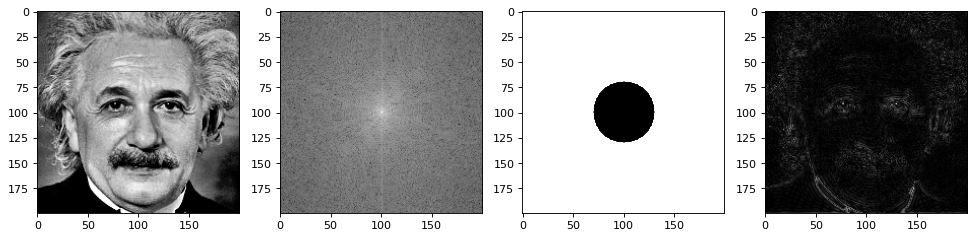

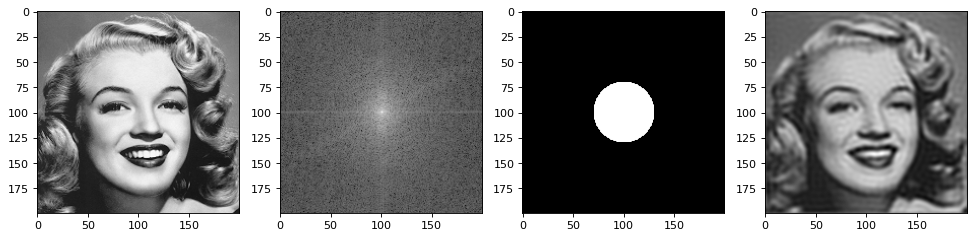

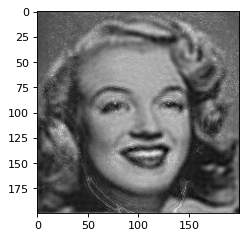

In [ ]:
plot(list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match)

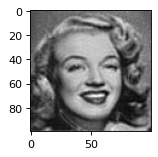

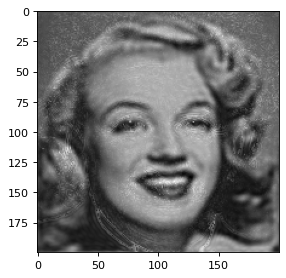

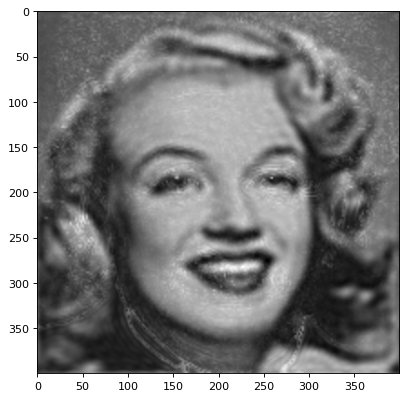

In [ ]:
plotMultiplesSizes(img_match)

In [ ]:
list_fnames = ["einstein.png","monroe.png"]
list_radius = [20,15]
list_type_pass = ["high_pass","low_pass"]
list_type_filter = ["gaussian","gaussian"]

A combinação do filtro gaussiano, que é menos abrupto que o ideal, ao permitir passagem de frequências altas/baixas produziu um melhor resultado

In [ ]:
list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match = matchImages(list_fnames, 
                                                                                           list_radius, 
                                                                                           list_type_filter,
                                                                                           list_type_pass)

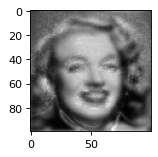

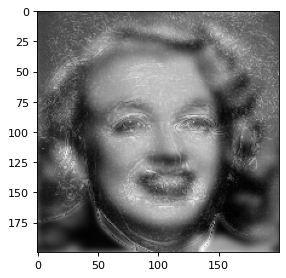

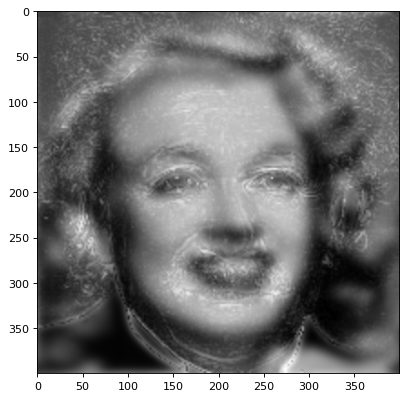

In [ ]:
plotMultiplesSizes(img_match)

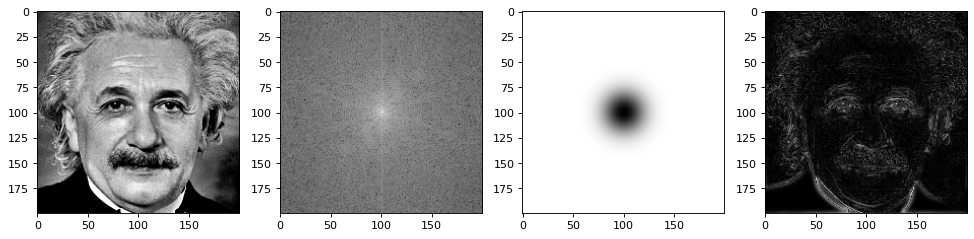

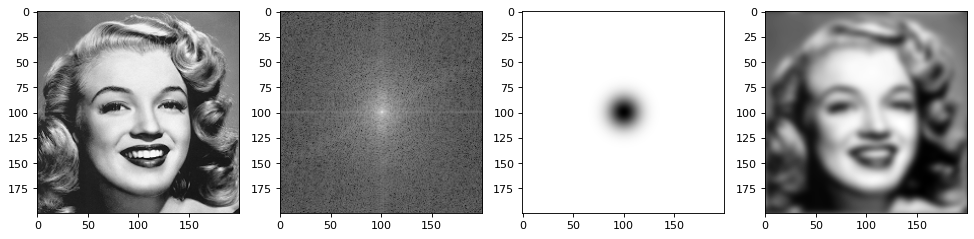

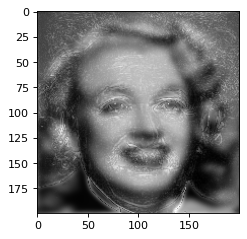

In [ ]:
plot(list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match)

In [ ]:
list_fnames = ["rabisco2.jpg","text3.jpg"]
list_radius = [20,20]
list_type_pass = ["low_pass","high_pass"]
list_type_filter = ["ideal","ideal"]

list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match = matchImages(list_fnames, 
                                                                                           list_radius, 
                                                                                           list_type_filter,
                                                                                           list_type_pass)

Por fim temos o real foco do trabalho que é ocultar caracteres em uma imagem. Nesse caso o filtro ideal se saiu muito bem

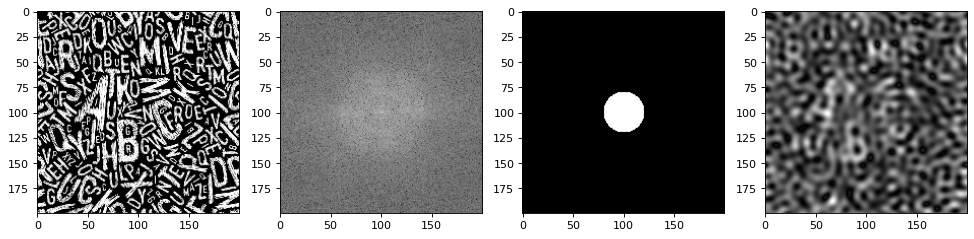

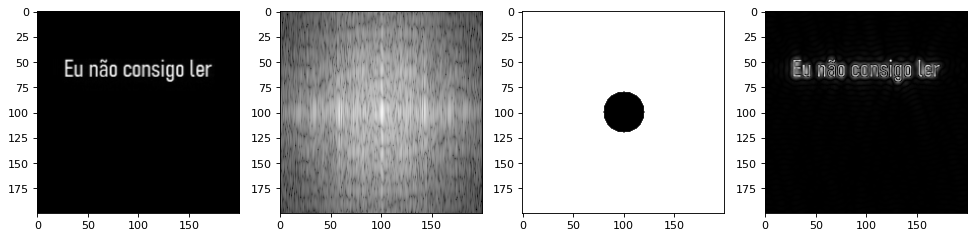

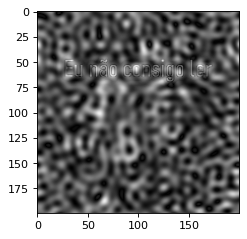

In [ ]:
plot(list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match)

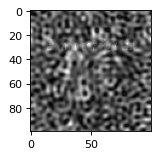

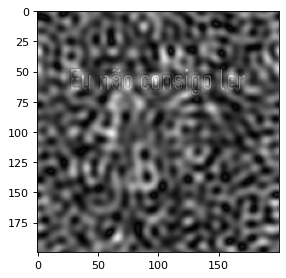

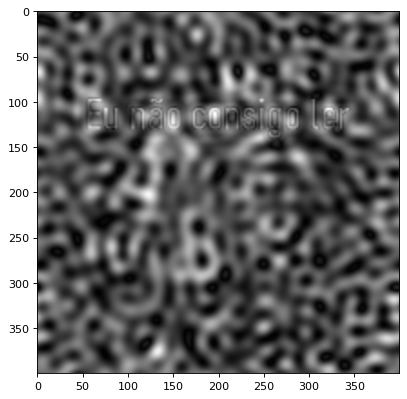

In [ ]:
plotMultiplesSizes(img_match)

O filtro gaussiano teve bons resultados mas foram um pouco pior que o ideal

In [ ]:
list_fnames = ["rabisco2.jpg","text3.jpg"]
list_radius = [20,20]
list_type_pass = ["low_pass","high_pass"]
list_type_filter = ["gaussian","gaussian"]

list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match = matchImages(list_fnames, 
                                                                                           list_radius, 
                                                                                           list_type_filter,
                                                                                           list_type_pass)

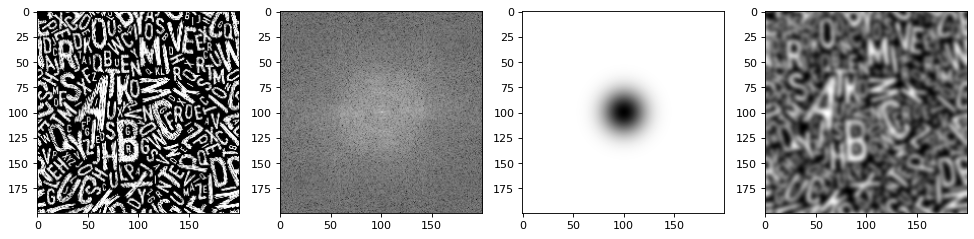

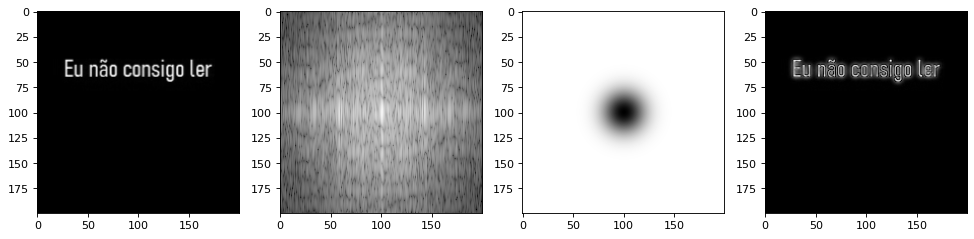

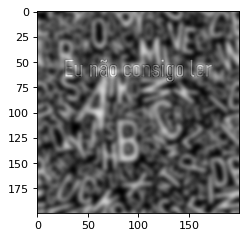

In [ ]:
plot(list_img_gray,list_img_filtered,list_magnetude_spectrum,list_masks,img_match)

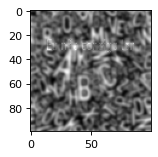

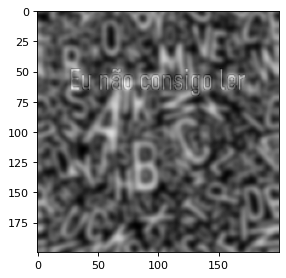

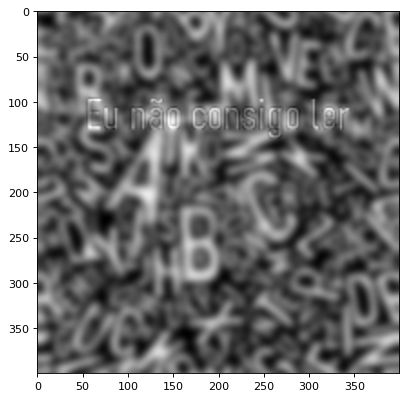

In [ ]:
plotMultiplesSizes(img_match)